In [1]:
# Imports
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import pandas as pd

from copy import deepcopy
from tqdm.notebook import tqdm

from scipy.stats import mode

In [2]:
def runge_kutta(time_steps, y0, system, params):
    ys = [y0]
    for t in range(len(time_steps)-1):
        dt = time_steps[t+1]-time_steps[t]
        t0 = time_steps[t]
        t1 = time_steps[t+1]
        k1 = system(t0, y0, params)
        k2 = system(t0 + dt/2, y0 + dt / 2 * k1, params)
        k3 = system(t0 + dt/2, y0 + dt / 2 * k2, params)
        k4 = system(t1, y0 + dt * k3, params)
        y0  = y0 + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)
        ys.append(y0)
    return np.array(ys)

def lorentz_ode(t, xyz, params):
    x, y, z = xyz
    σ = params['σ']
    ρ = params['ρ']
    β = params['β']
    
    dx = σ * (y - x)
    dy = x * (ρ - z) - y
    dz = x * y - β * z
    
    return np.array([dx, dy, dz])

def get_data_unnormalized(p1 = 10., p2 = 28., p3 = 8/3):
    time_steps = np.arange(0, 1500, 0.1)
    params = {'σ' : p1, 'ρ' : p2, 'β' : p3}
    xyz0 = np.array([1., 1., 1.])
    lorenz_solution = runge_kutta(time_steps, xyz0, lorentz_ode, params)
    x, y, z = lorenz_solution[2000:].T

    # x = (x - min(x)) / (max(x) - min(x))
    return x

In [3]:
# Hyper params
L = 4
K = 10
eps = 0.01
beta = 1

train_points_number = 5000

In [4]:
# Builds matrix of patterns
z_vectors = np.array(list(product(np.arange(1, K + 1), repeat=L)))
patterns = np.cumsum(z_vectors, axis=1)
patterns = np.hstack([np.zeros((z_vectors.shape[0], 1)), patterns]).astype(int)

train_patterns_size = int(beta * patterns.shape[0])

# patterns = patterns[np.random.choice(np.arange(patterns.shape[0]), train_patterns_size)]

In [5]:
def fit_normalized(train_data, start_index):
    global patterns, train_points_number

    z_vectors_list = []
    for i in tqdm(range(patterns.shape[0]), desc=f"Computing matrix of Z-vectors", leave=False):
        pattern = patterns[i]
        vecs = []
        for j in range(train_points_number - pattern[-1] - start_index):
            vecs.append(train_data[pattern + j + start_index])
        vecs = np.array(vecs)
        vecs[:] = (vecs[:] - vecs[:, :-1].min(axis=1, keepdims=True)) / (vecs[:, :-1].max(axis=1, keepdims=True) - vecs[:, :-1].min(axis=1, keepdims=True))
        z_vectors_list.append(vecs)

    return z_vectors_list

In [6]:
def norm(a):
    return np.sqrt(np.sum(np.square(a), axis=1))

In [16]:
def predict_with_demon(train_data, X, predicted_points_number, start):
  global train_points_number, patterns, eps

  x_with_predictions = deepcopy(train_data)
  predictions = []
  for T in tqdm(range(start + train_points_number, start + train_points_number + predicted_points_number), desc="Demon predictions", leave=False):
      St = []
      for i in tqdm(range(patterns.shape[0]), desc="Inner loop", leave=False):
          arr = x_with_predictions[(patterns[i] + T - patterns[i][-1])[:-1]]
          mn = np.min(arr)
          mx = np.max(arr)
          arr = (arr - mn) / (mx - mn)
          normalized_predicted = norm(X[i][:, :-1] - arr)
          St.extend(X[i][(normalized_predicted < eps), :][:, -1] * (mx - mn) + mn)
      if len(St) == 0:
         predicted_value = np.inf
      else:
         predicted_value = mode(St, keepdims=False)[0]
         if abs(train_data[T] - predicted_value) / train_data[T] > 0.05:
            predicted_value = np.inf
      predictions.append(predicted_value)
      x_with_predictions[T] = predicted_value
  return predictions

In [8]:
x = get_data_unnormalized()
points_number = x.shape[0]

start = 0
predicted_points_number = 50

In [9]:
X = fit_normalized(x, start)

Computing matrix of Z-vectors:   0%|          | 0/10000 [00:00<?, ?it/s]

In [10]:
def normalize(arr):
    return (arr - min(arr)) / (max(arr) - min(arr))

In [17]:
actual_vals = x[start + train_points_number : start + train_points_number + predicted_points_number]
predicted_vals = predict_with_demon(x, X, predicted_points_number, start)

Demon predictions:   0%|          | 0/50 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_11516\1757159705.py:12: RuntimeWarning: invalid value encountered in divide
  arr = (arr - mn) / (mx - mn)


Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_11516\1757159705.py:12: RuntimeWarning: invalid value encountered in subtract
  arr = (arr - mn) / (mx - mn)
C:\Users\alex\AppData\Local\Temp\ipykernel_11516\1757159705.py:12: RuntimeWarning: invalid value encountered in double_scalars
  arr = (arr - mn) / (mx - mn)
C:\Users\alex\AppData\Local\Temp\ipykernel_11516\1757159705.py:14: RuntimeWarning: invalid value encountered in double_scalars
  St.extend(X[i][(normalized_predicted < eps), :][:, -1] * (mx - mn) + mn)


Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

Inner loop:   0%|          | 0/10000 [00:00<?, ?it/s]

C:\Users\alex\AppData\Local\Temp\ipykernel_11516\2012344227.py:6: RuntimeWarning: invalid value encountered in divide
  plt.plot((predicted_vals - mn) / (mx - mn), "o", label="Predicted")


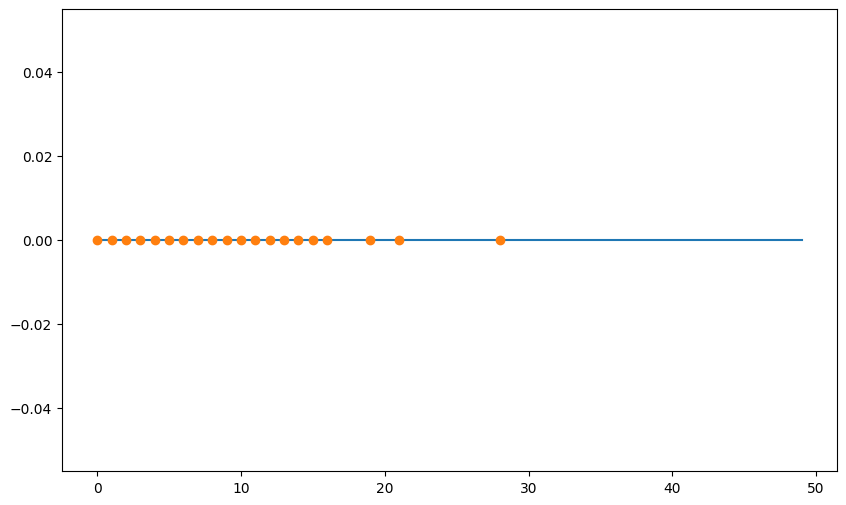

In [18]:
mn = min(min(actual_vals), min(predicted_vals))
mx = max(max(actual_vals), max(predicted_vals))

plt.figure(figsize=(10, 6))
plt.plot((actual_vals - mn) / (mx - mn), label="Actual")
plt.plot((predicted_vals - mn) / (mx - mn), "o", label="Predicted")
plt.show()

In [15]:
(predicted_vals - mn) / (mx - mn)

C:\Users\alex\AppData\Local\Temp\ipykernel_11516\2428571978.py:1: RuntimeWarning: invalid value encountered in divide
  (predicted_vals - mn) / (mx - mn)


array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0., nan, nan,  0., nan,  0., nan, nan, nan, nan,
       nan, nan,  0., nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])